#  Generalized Linear Models - Hidden Markov Models

In this notebook, we will demonstrate how to fit Generalized Linear Models - Hidden Markov Model (GLM-HMMs), also known as switching regression models. These models extend standard HMMs by incorporating generalized linear models (GLMs) as the state-dependent emissions. This allows the model to capture dynamic relationships between multiple variables.

This tutorial will cover:

    1. Defining and initializing an GLM-HMM
    2. Simulating data from a switching regression model
    3. Learning model parameters from observed sequences
    4. Inferring hidden states and their impact on regression dynamics
    5. Evaluating model performance

For foundational HMM theory, refer to Chapter 13 of Pattern Recognition and Machine Learning by Christopher Bishop, which includes discussions on extensions beyond standard HMMs.

# Setup

In [8]:
# Import the relevant packages
using LinearAlgebra
using Plots
using Random
using StateSpaceDynamics

# For convenience
const SSD = StateSpaceDynamics

StateSpaceDynamics

# Initializing a Switching Gaussian Regression #

StateSpaceDynamics.jl supports multiple switching regression models including gaussian, bernoulli, poisson, and autoregressive. We will first demonstrate the functionality on a switching gaussian regression and then give an example of a switching autoregression.

Recovered Emission 1? :true
Recovered Emission 2? :true


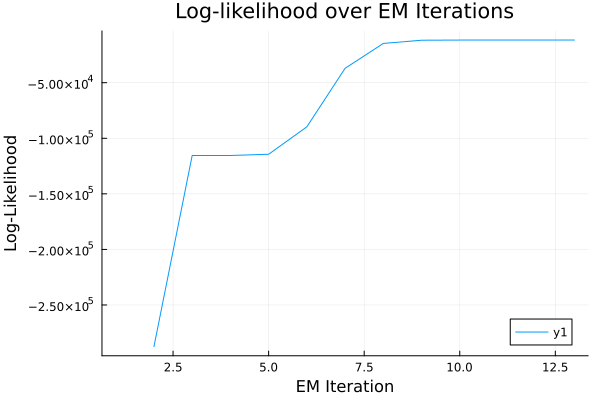

In [2]:
# Create Emission Models
emission_1 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([3, 2, 2, 3], :, 1))
emission_2 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-4.0, -2.0, 3.0, 2.0], :, 1))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)
true_model.A = [0.99 0.01; 0.05 0.95]

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n = 20000
Φ = randn(3, n)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Fit a new model to the data
test_model = SSD.SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)
lls = SSD.fit!(test_model, data, Φ)

# Show that we can recover the parameters properly
println("Recovered Emission 1? :", isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.1) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.1))
println("Recovered Emission 2? :", isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.1) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.1))

plot(lls)
title!("Log-likelihood over EM Iterations")
xlabel!("EM Iteration")
ylabel!("Log-Likelihood")

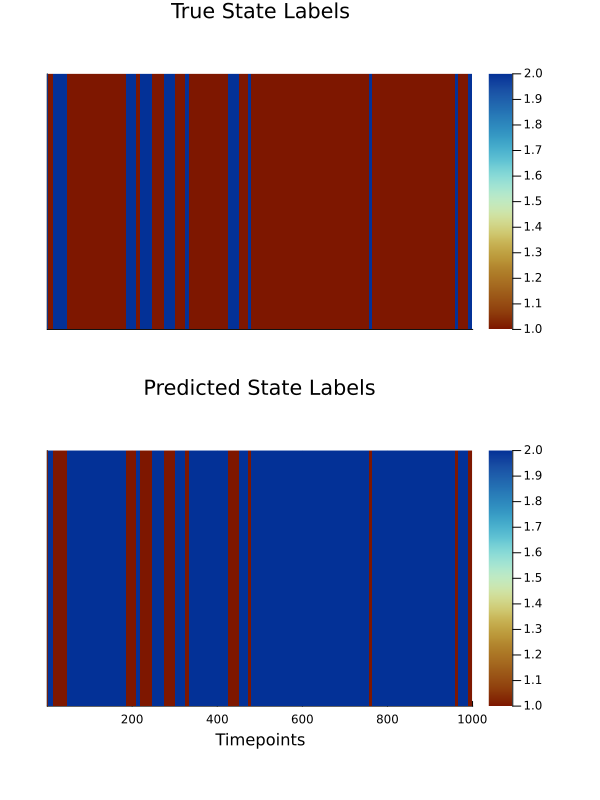

In [3]:
# Plot hidden state decoding from fit model vs. true state labels
pred_labels= viterbi(test_model, data, Φ);

# Additionally we can use the following function to get probabilities rather than most likely state labels
state_probabilities = class_probabilities(test_model, data, Φ);

# Create heatmaps
p1 = heatmap(true_labels[1:1000]', colormap=:roma50, title="True State Labels", xlabel="", ylabel="", xticks=false, yticks=false)
p2 = heatmap(pred_labels[1:1000]', colormap=:roma50, title="Predicted State Labels", xlabel="Timepoints", ylabel="", xticks=true, yticks=false)

# Combine into subplots
plot(p1, p2, layout=(2, 1), size=(600, 800), margin=10Plots.mm)

# Data with Multiple Trials

Recovered Emission 1? :true
Recovered Emission 2? :false


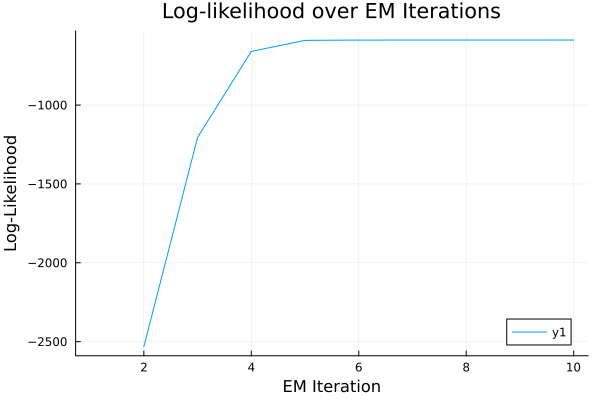

In [4]:
emission_1 = GaussianRegressionEmission(input_dim=2, output_dim=1, include_intercept=false, β=reshape([2.0 1.0 ], :, 1))
emission_2 = GaussianRegressionEmission(input_dim=2, output_dim=1, include_intercept=false, β=reshape([-2.0 -1.0], :, 1))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=2, input_dim=2, output_dim=1, include_intercept=false)
true_model.A = [0.99 0.01; 0.05 0.95]

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
all_data = Vector{Matrix{Float64}}()  # Store each data matrix
Φ_total = Vector{Matrix{Float64}}()

num_trials = 1000
n=1000
all_true_labels = []

for i in 1:num_trials
    Φ = randn(2, n)
    true_labels, data = SSD.sample(true_model, Φ, n=n)
    push!(all_true_labels, true_labels)
    push!(all_data, data)
    push!(Φ_total, Φ)
end


emission_1 = GaussianRegressionEmission(input_dim=2, output_dim=1, include_intercept=false, β=reshape([3.0 0.05 ], :, 1))
emission_2 = GaussianRegressionEmission(input_dim=2, output_dim=1, include_intercept=false, β=reshape([-10.0 -20.0], :, 1))

# Create Switching Regression Model
test_model = SwitchingGaussianRegression(K=2, input_dim=2, output_dim=1, include_intercept=false)
test_model.A = [0.99 0.01; 0.05 0.95]

# Plug in the emission models
test_model.B[1] = emission_1
test_model.B[2] = emission_2

# Fit the model to the sampled data
lls = SSD.fit!(test_model, data, Φ)

# Show that we can recover the parameters properly
println("Recovered Emission 1? :", isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.1) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.1))
println("Recovered Emission 2? :", isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.1) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.1))

plot(lls)
title!("Log-likelihood over EM Iterations")
xlabel!("EM Iteration")
ylabel!("Log-Likelihood")

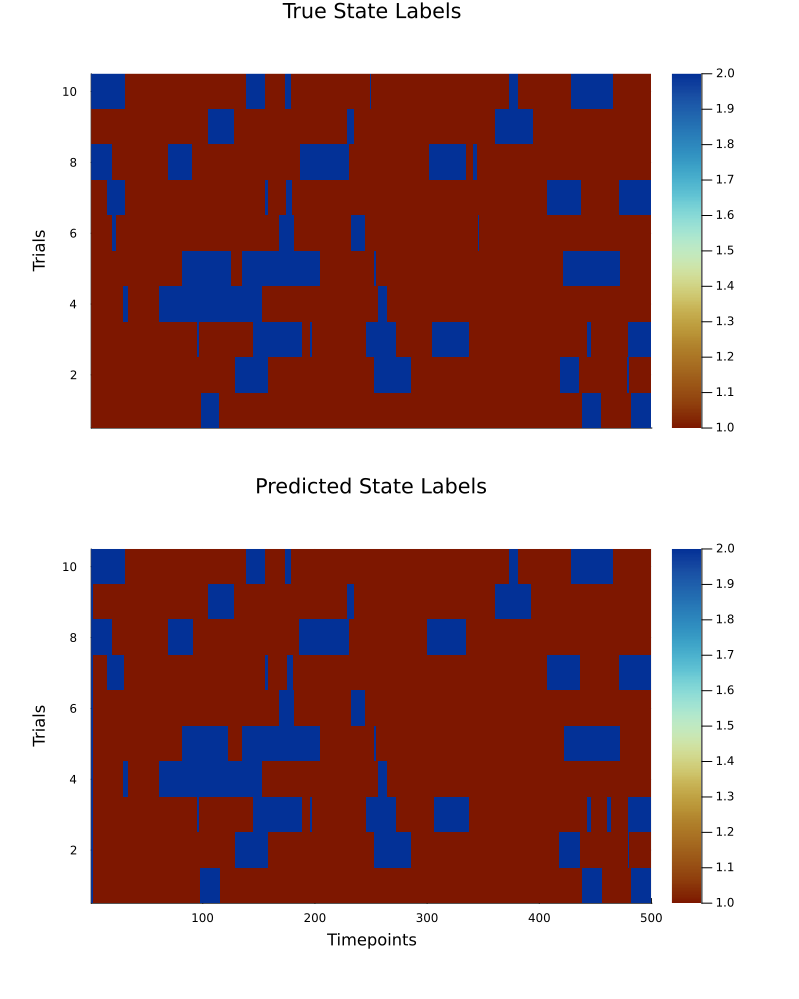

In [5]:
"""
Heatmaps of state labels
"""

# Preallocate storage for predicted labels
all_pred_labels = Matrix{Int}(undef, num_trials, n)

# Compute predicted state labels for each trial
for i in 1:num_trials
    all_pred_labels[i, :] = viterbi(test_model, all_data[i], Φ_total[i])  # Decode hidden states
end

# Stack true labels into a matrix for heatmap plotting
all_true_labels_matrix = hcat(all_true_labels...)'

# Create heatmaps for multiple trials
p1 = heatmap(all_true_labels_matrix[1:10, 1:500], colormap=:roma50, title="True State Labels", xlabel="", ylabel="Trials", xticks=false, yticks=true)
p2 = heatmap(all_pred_labels[1:10, 1:500], colormap=:roma50, title="Predicted State Labels", xlabel="Timepoints", ylabel="Trials", xticks=true, yticks=true)

# Combine into subplots
plot(
    p1, p2, 
    layout=(2, 1), 
    size=(800, 1000), 
    margin=10Plots.mm
)

# Autoregressive HMM

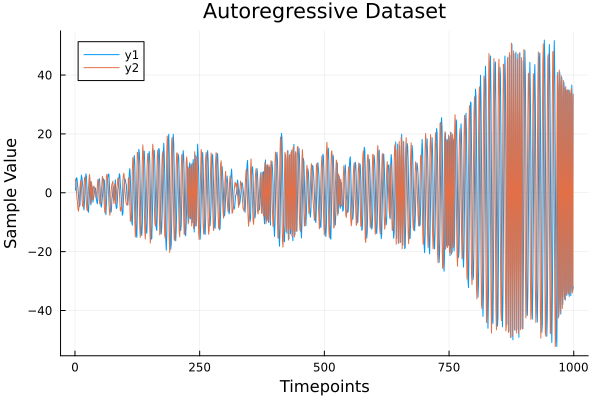

In [6]:
"""
Construct the AR HMM
"""
# Create autoregressive emission models -> one growing, one shrinking
AR_emission_1 = AutoRegressionEmission(output_dim=2, order=1, include_intercept=false, β=[0.8 -0.6; 0.6 0.8]);
AR_emission_2 = AutoRegressionEmission(output_dim=2, order=1, include_intercept=false, β=[0.0 -1.0; 1.0 0.0]);

# Create the autoregressive model and plug in emission models
true_model = SSD.SwitchingAutoRegression(K=2, output_dim=2, order=1);
true_model.A = [0.98 0.02; 0.05 0.95];
true_model.B[1] = AR_emission_1;
true_model.B[2] = AR_emission_2;

# Sample from the AR HMM
# Note, that we need a starting point to sample from a switching autoregression. I am using a sample from the above Gaussian Regression which has the same dimensions.
Y = SSD.construct_AR_feature_matrix(data, 1, false);
X = copy(Y[:, end]);
X = reshape(Y[:, end], 2, 1);
AR_labels, AR_data = SSD.sample(true_model, X, n=1000, autoregressive=true);

# Define the autoregressive order and dimensions
order = 1;
num_samples = size(AR_data, 2);
output_dim = size(AR_data, 1);

# align  Φ (inputs) and Y (outputs) for regression
Φ = AR_data[:, 1:(num_samples - 1)];  # Input: All time steps except the last
Y = AR_data[:, 2:num_samples];        # Output: All time steps except the first

# Visualize the dataset
plot(Y')
title!("Autoregressive Dataset")
xlabel!("Timepoints")
ylabel!("Sample Value")

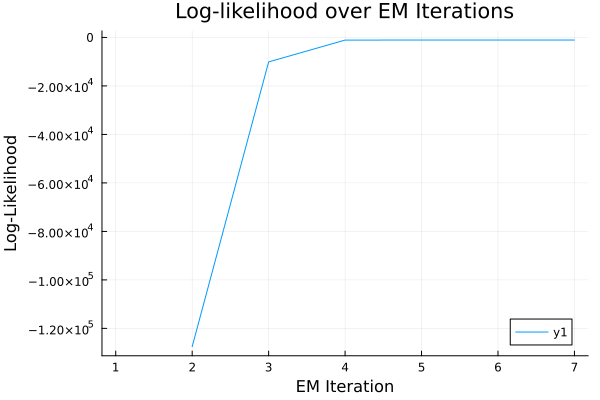

In [7]:
# Fit a new autoregressive model
# Create autoregressive emission models
AR_emission_1 = AutoRegressionEmission(output_dim=2, order=1, include_intercept=false, β=[0.5 -0.1; 0.2 0.3])
AR_emission_2 = AutoRegressionEmission(output_dim=2, order=1, include_intercept=false, β=[0.2 -2.0; 0.8 0.1])

# Create the autoregressive model and plug in emission models
test_model = SSD.SwitchingAutoRegression(K=2, output_dim=2, order=1)
test_model.B[1] = AR_emission_1
test_model.B[2] = AR_emission_2
test_model.A = [0.8 0.2; 0.2 0.8]

lls = SSD.fit!(test_model, Y, Φ, max_iters=200)

plot(lls)
title!("Log-likelihood over EM Iterations")
xlabel!("EM Iteration")
ylabel!("Log-Likelihood")

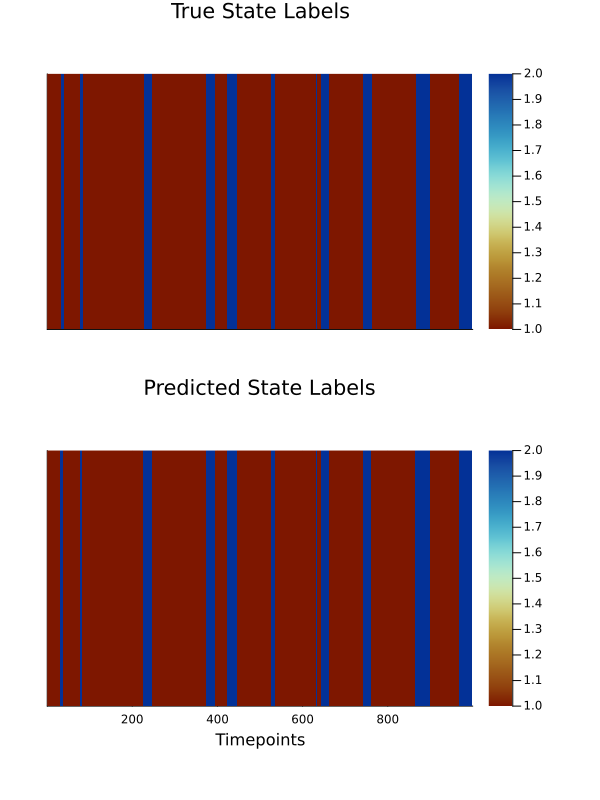

In [8]:
# Plot hidden state decoding from fit model vs. true state labels
pred_labels= viterbi(test_model, Y, Φ);

# Create heatmaps
p1 = heatmap(AR_labels[1:999]', colormap=:roma50, title="True State Labels", xlabel="", ylabel="", xticks=false, yticks=false)
p2 = heatmap(pred_labels[1:999]', colormap=:roma50, title="Predicted State Labels", xlabel="Timepoints", ylabel="", xticks=true, yticks=false)

# Combine into subplots
plot(p1, p2, layout=(2, 1), size=(600, 800), margin=10Plots.mm)